# Trabajo Final - Planning - MAIE
En la presente notebook se realizará el trabajo final de la materia Planning de la MAIE, y se explicará paso a paso su resolución. Primero, seleccionar la fecha a procesar en la variable ***fecha*** de la forma YYYY-MM-DD en formato string

In [140]:
# ----- Elegir fecha a procesar -----
# fecha = '2023-01-06'
# fecha = '2023-05-14'
fecha = '2024-02-10'

# ----------------------------------------------------------
# ----- NO MODIFICAR: Importación de librarías -------------
# ----------------------------------------------------------
import os
import sys
import glob
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal
gdal.UseExceptions()

# -----------------------------------------
# ----- NO MODIFICAR: CHEQUEO -------------
# -----------------------------------------
path = os.getcwd()

# Verifico que exista la carpeta de datos, si no lanzo error
if not os.path.exists(f'{path}/datos'):
    raise Exception(
        '''
        No existe la carpeta "datos" en el directorio actual.
        Verificar que el path de ejecución sea donde se clonó el repositorio
        ''')
path_datos = f'{path}/datos'

# Verifico que exista la carpeta de procesamiento, si no la creo
if not os.path.exists(f'{path}/procesamiento'):
    os.system(f'mkdir {path}/procesamiento')
path_proc = f'{path}/procesamiento'

# Verifico que exista la carpeta de resultados, si no la creo
if not os.path.exists(f'{path}/plots'):
    os.system(f'mkdir {path}/plots')
path_plots = f'{path}/plots'

# Verifico que exista la fecha a procesar
# Los-Molinos_2023-01-06_0_all_bands
datos_path_list = glob.glob(f'{path_datos}/Los-Molinos_{fecha}_*_all_bands.zip')
if len(datos_path_list) == 0:
    raise Exception(f'No se encontraron datos para la fecha {fecha}')
elif len(datos_path_list) == 1:
    path_file = datos_path_list[0]
    print(f'Existe un único archivo de datos para la fecha {fecha}. Continuar ejecución')
else:
    raise ValueError(f'Existen {len(datos_path_list)} archivos para la fecha {fecha}. Verificar, se aborta la ejecución')

Existe un único archivo de datos para la fecha 2024-02-10. Continuar ejecución


A continuación, descomprimirá el zip en la carpeta ***procesamiento*** y obtengo los links de cada banda

In [141]:
# Creo subcarpeta de extacción, si existe, elimino el contenido
path_proc_fecha = f'{path_proc}/{fecha}'
if not os.path.exists(path_proc_fecha):
    os.system(f'mkdir {path_proc_fecha}')
else:
    os.system(f'rm -r {path_proc_fecha}/*')

# Decomprimo path_file a path_proc    
with zipfile.ZipFile(path_file, 'r') as zip_ref:
    zip_ref.extractall(path_proc_fecha)
    print('-'*80)
    print(f'Archivo:\n{path_file.replace(path, '')}\nDescomprimido en:\n{path_proc_fecha.replace(path, '')}/')
    print('-'*80)

# Obtengo los paths de las bandas
path_bands = glob.glob(f'{path_proc_fecha}/*.tif')

# Controlo que se hayan encontrado archivos
if len(path_bands) == 0:
    raise ValueError('No se encontraron los archivos decomprimidos, revisar código')

print('Las bandas encontradas son:')
for band in path_bands:
    print(band.split('/')[-1].split('.')[1])

--------------------------------------------------------------------------------
Archivo:
/datos/Los-Molinos_2024-02-10_0_all_bands.zip
Descomprimido en:
/procesamiento/2024-02-10/
--------------------------------------------------------------------------------
Las bandas encontradas son:
SR_B1
SR_B2
SR_B3
SR_B4
SR_B5
SR_B6
SR_B7
ST_B10
QA_PIXEL


Defino todas las funciones que se utilizarán más adelante, para mayor claridad

In [142]:
def select_band(paths, band):
    return [path for path in paths if band in path][0]

def get_band_name(path):
    return path.split('/')[-1].split('.')[1]

def path_to_arr(path):
    """Devuelve un array de una imagen"""
    return gdal.Open(path).ReadAsArray()

def get_trans_proj(path):
    ds = gdal.Open(path)
    ds_GeoTransform = ds.GetGeoTransform()
    ds_Projection = ds.GetProjection()
    return ds_GeoTransform, ds_Projection

def get_nodato(path, band=1):
    """Devuelve el valor de NoData de una imagen"""
    ds = gdal.Open(path)
    nodato = ds.GetRasterBand(band).GetNoDataValue()
    tipo_nodato = ds.GetRasterBand(band).DataType
    tipo_nodato = gdal.GetDataTypeName(tipo_nodato)
    return nodato, tipo_nodato

def preprocess_tif(mtx, nodato):
    # Transformo a float si no lo está
    mtx = mtx.astype(np.float32)
    # Enmascaro
    mtx[mtx == nodato] = np.nan
    return mtx

def get_n_bit_value(arr, n_bit):
    """Devuelve el valor del n_bit para todo el array"""
    return (arr & (1 << n_bit)) >> n_bit

def write_to_disk(arr, path, ds_transform, ds_projection, dtype=gdal.GDT_Float32, compress='DEFLATE', no_data_value=np.nan):
    """Write a numpy array to disk as a raster with multiple bands."""
    driver = gdal.GetDriverByName('GTiff')
    if len(arr.shape) == 2:  # If the array is 2D, add a third dimension
        arr = arr[:, :, np.newaxis]
    num_bands = arr.shape[2]  # Get the number of bands from the third dimension of the array
    ds = driver.Create(path, arr.shape[1], arr.shape[0], num_bands, dtype, options=[f'COMPRESS={compress}'])

    ds.SetGeoTransform(ds_transform)
    ds.SetProjection(ds_projection)

    for band_num in range(num_bands):
        band = ds.GetRasterBand(band_num + 1)  # Bands are 1-indexed
        band.SetNoDataValue(no_data_value)  # Set NaNs as the nodata value
        band.WriteArray(arr[:, :, band_num])  # Write the corresponding band to the dataset

    ds.FlushCache()
    ds = None

Realizo un análisis exploratorio de los datos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


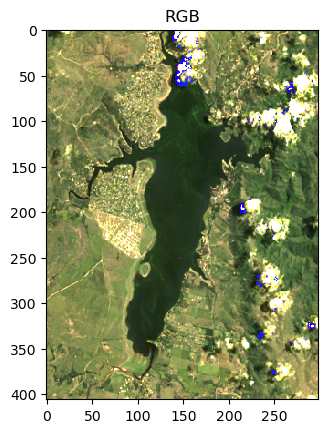

--------------------------------------------------------------------------------
		 Análisis exploratorio de la banda SR_B1
Dimensiones = 406 x 298
Valor de no dato = 0.0 del tipo UInt16
Mínimo = 78.0 --- Promedio = 8142.03 --- Máximo = 27336.0
--------------------------------------------------------------------------------
		 Análisis exploratorio de la banda SR_B2
Dimensiones = 406 x 298
Valor de no dato = 0.0 del tipo UInt16
Mínimo = 98.0 --- Promedio = 8510.44 --- Máximo = 28282.0
--------------------------------------------------------------------------------
		 Análisis exploratorio de la banda SR_B3
Dimensiones = 406 x 298
Valor de no dato = 0.0 del tipo UInt16
Mínimo = 4222.0 --- Promedio = 9598.50 --- Máximo = 28590.0
--------------------------------------------------------------------------------
		 Análisis exploratorio de la banda SR_B4
Dimensiones = 406 x 298
Valor de no dato = 0.0 del tipo UInt16
Mínimo = 4210.0 --- Promedio = 9439.52 --- Máximo = 29001.0
----------------

In [143]:
# Genero RGB y lo muestro
path_red = select_band(path_bands, 'B4')
path_green = select_band(path_bands, 'B3')
path_blue = select_band(path_bands, 'B2')
RGB = np.dstack((path_to_arr(path_red), path_to_arr(path_green), path_to_arr(path_blue)))
RGB_min = 7000
RGB_max = 12000
plt.imshow((RGB-RGB_min)/(RGB_max-RGB_min), interpolation='nearest')
plt.title('RGB')
plt.show()

# Calculo estadísticas de las bandas
for band_path in path_bands:
    band_mtx = path_to_arr(band_path)
    nodato, tipo_nodato = get_nodato(band_path)
    band_mtx = preprocess_tif(band_mtx, nodato)
    print('-'*80)
    print(f'\t\t Análisis exploratorio de la banda {get_band_name(band_path)}')
    print(f'Dimensiones = {' x '.join(list(map(str, band_mtx.shape)))}')
    print(f'Valor de no dato = {nodato} del tipo {tipo_nodato}')
    print(f'Mínimo = {np.nanmin(band_mtx)} --- Promedio = {np.nanmean(band_mtx):.2f} --- Máximo = {np.nanmax(band_mtx)}')

Identifico outliers con la banda de QA según README. Guardo en memoria todas las bandas enmascaradas por nodato y por QA.

In [144]:
QA = path_to_arr(select_band(path_bands, 'QA'))
validos_segun_QA = (
    (get_n_bit_value(QA, 0) == 0) *
    (get_n_bit_value(QA, 2) == 0) *
    (get_n_bit_value(QA, 3) == 0) *
    (get_n_bit_value(QA, 4) == 0)
    )
print(f'Porcentaje de datos válidos según QA: {100*np.mean(validos_segun_QA):.2f}%')
print(f'Cantidad de píxeles eliminados según QA: {int(np.sum(~validos_segun_QA))}')

def select_band_and_process(paths, band_str):
    path_mtx = select_band(paths, band_str)
    mtx = path_to_arr(path_mtx)
    nodato, tipo_nodato = get_nodato(path_mtx)
    mtx = preprocess_tif(mtx, nodato)
    mtx[~validos_segun_QA] = np.nan
    return mtx

B1 = select_band_and_process(path_bands, 'B1')
B2 = select_band_and_process(path_bands, 'B2')
B3 = select_band_and_process(path_bands, 'B3')
B4 = select_band_and_process(path_bands, 'B4')
B5 = select_band_and_process(path_bands, 'B5')
B6 = select_band_and_process(path_bands, 'B6')
B7 = select_band_and_process(path_bands, 'B7')
B10 = select_band_and_process(path_bands, 'B10')
print('Cargadas todas las bandas en memoria! Y enmascaradas!')

Porcentaje de datos válidos según QA: 90.33%
Cantidad de píxeles eliminados según QA: 11700
Cargadas todas las bandas en memoria! Y enmascaradas!


Genero índice de MNDWI para generar la máscara de agua/no-agua con su fórmula para Landsat 8:

$MNDWI = \frac{Banda 3 \;\;–\;\; Banda 6}{Banda 3 \;\;+\;\; Banda 6}$

Luego se genera un histograma y se queda como threshold al valor mínimo del histograma más cercano al valor de threshold de Otsu. El valor mínimo se calcula suavizando el histograma y derivando.

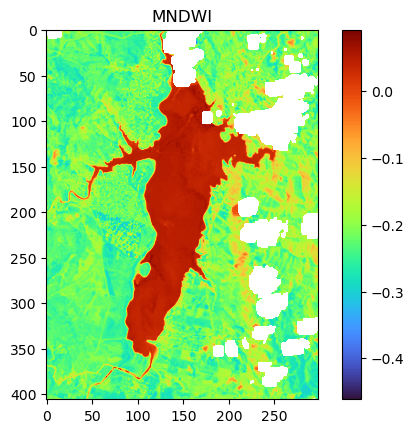

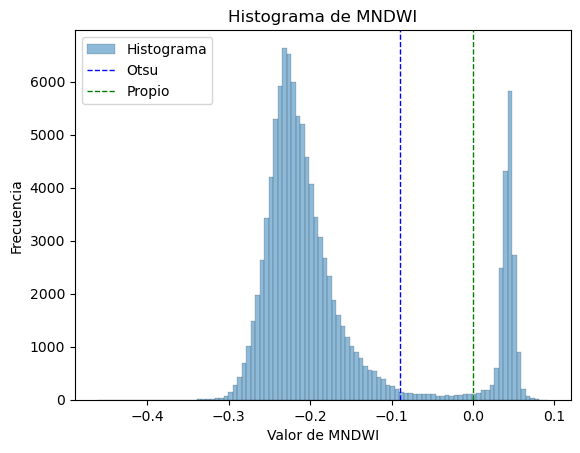

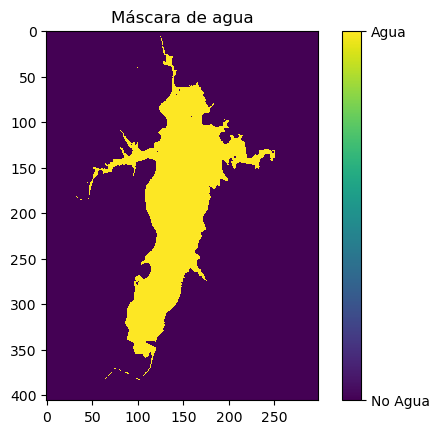

In [148]:
MNDWI = (B3 - B6) / (B3 + B6)

# Grafico MNDWI
plt.imshow(MNDWI, cmap='turbo')
plt.title('MNDWI')
plt.colorbar()
plt.show()

def otsu(gray_in):
    """Calcula el umbral de Otsu para una imagen en escala de grises
    Adaptado desde: https://stackoverflow.com/questions/48213278/implementing-otsu-binarization-from-scratch-python"""
    vmin = np.nanmin(gray_in)
    vmax = np.nanmax(gray_in)
    gray = (gray_in - vmin) / (vmax - vmin) * 255
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weight = 1.0/pixel_number
    his, bins = np.histogram(gray, np.arange(0,257))
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)
    for t in bins[1:-1]: # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
        pcb = np.sum(his[:t])
        pcf = np.sum(his[t:])
        Wb = pcb * mean_weight
        Wf = pcf * mean_weight

        mub = np.sum(intensity_arr[:t]*his[:t]) / float(pcb)
        muf = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)
        #print mub, muf
        value = Wb * Wf * (mub - muf) ** 2

        if value > final_value:
            final_thresh = t
            final_value = value
    final_img = gray.copy()
    final_img[gray > final_thresh] = 1
    final_img[gray < final_thresh] = 0
    # Re adapto final_thresh
    otsu_thresh = vmin + final_thresh * (vmax - vmin) / 255
    return final_img, otsu_thresh

_, otsu_thresh = otsu(MNDWI)

# Obtengo array del histograma
hist, bins = np.histogram(MNDWI[~np.isnan(MNDWI)], bins=100)
# Paso a x e y
x = (bins[:-1] + bins[1:]) / 2
y = hist
# Suavizado
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
y_smooth = np.convolve(y, kernel, mode='full')
# Derivo
dydx = np.gradient(y_smooth)
# Busco mínimos locales
minimos = np.where((np.diff(np.sign(dydx)) > 0) & (dydx[:-1] < 0))[0]
# Elijo el mínimo más cercano al valor de Otsu
# my_thresh = x[minimos[np.argmin(np.abs(x[minimos] - otsu_thresh))]]

my_thresh = 0
# Genero máscara binaria
mascara = np.where(MNDWI > my_thresh, 1, 0)

# Grafico
plt.hist(MNDWI[~np.isnan(MNDWI)], bins=100, alpha=0.5, edgecolor='black', linewidth=0.2, label='Histograma')
# plt.plot(x, y_smooth, c='red', label='Histograma suavizado')
plt.axvline(otsu_thresh, color='b', linestyle='dashed', linewidth=1, label='Otsu')
plt.axvline(my_thresh, color='g', linestyle='dashed', linewidth=1, label='Propio')
plt.title('Histograma de MNDWI')
plt.xlabel('Valor de MNDWI')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

plt.imshow(mascara, interpolation='none')
plt.title('Máscara de agua')
plt.colorbar(ticks=[0, 1], format=plt.FuncFormatter(lambda x, _: ['No Agua', 'Agua'][int(x)]))
plt.show()

# Recorto las bandas con la máscara
B1 = np.where(mascara, B1, np.nan)
B2 = np.where(mascara, B2, np.nan)
B3 = np.where(mascara, B3, np.nan)
B4 = np.where(mascara, B4, np.nan)
B5 = np.where(mascara, B5, np.nan)
B6 = np.where(mascara, B6, np.nan)
B7 = np.where(mascara, B7, np.nan)
B10 = np.where(mascara, B10, np.nan)

Genero índice de NDVI con el recorte realizado con su fórmula para Lansat 8:

$NDVI = \frac{Banda 5 \;\;–\;\; Banda 4}{Banda 5 \;\;+\;\; Banda 4}$

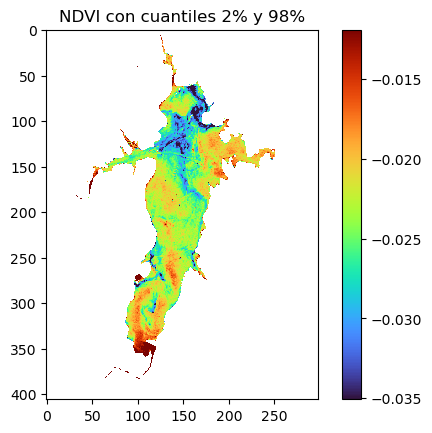

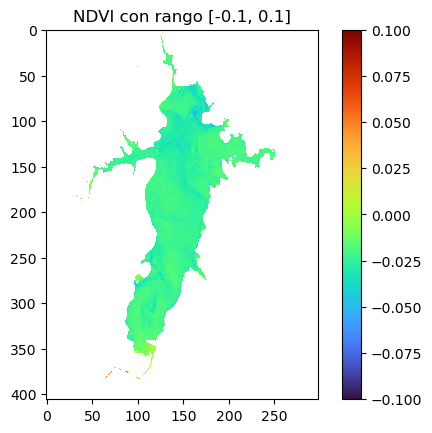

In [152]:
NDVI = (B4 - B3) / (B4 + B3)

# Grafico NDVI
vmin = np.nanquantile(NDVI, 0.02)
vmax = np.nanquantile(NDVI, 0.98)
plt.imshow(NDVI, cmap='turbo', vmin=vmin, vmax=vmax, interpolation='none')
plt.title('NDVI con cuantiles 2% y 98%')
plt.colorbar()
plt.show()

# Grafico NDVI
vmin = -0.1
vmax = 0.1
plt.imshow(NDVI, cmap='turbo', vmin=vmin, vmax=vmax, interpolation='none')
plt.title('NDVI con rango [-0.1, 0.1]')
plt.colorbar()
plt.show()
